In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import default_rng
rng = default_rng()


In [3]:
# df = pd.read_csv("../results/fbs/ab-main-main-2022-08-26T11:51:31+02:00/combined-results.csv")
# df = pd.read_csv("../results/fbs/ab-main-main-2022-08-26T12:54:59+02:00/combined-results.csv")
#df = pd.read_csv("../results/fbs/ab-main-main-2022-08-26T17:21:30+02:00/combined-results.csv")
#df = pd.read_csv("../results/fbs/ab-main-perf-issue-request-id-2022-08-26T10:31:36+02:00/combined-results.csv")
#df = pd.read_csv("../results/fbs/ab-main-perf-issue-clean-path-2022-08-26T13:17:48+02:00/combined-results.csv")
df = pd.read_csv("../results/fbs/ab-main-perf-issue-clean-path-2022-09-01T14:42:09+02:00/combined-results.csv")
df["version_scenario"] = df["version"] + "_" + df["scenario"]
df

,version,index,period,width,scenario,method,path,request_time_median,request_count,version_scenario
0,v1,0,1662036140000,3122,searchFlights,GET,/destinations,8.9,22,v1_searchFlights
1,v1,0,1662036140000,3122,searchFlights,GET,/flights,7.0,34,v1_searchFlights
2,v1,0,1662036140000,3122,searchAndBookFlight,GET,/destinations,7.9,11,v1_searchAndBookFlight
3,v1,0,1662036140000,3122,searchAndBookFlight,GET,/flights,7.9,6,v1_searchAndBookFlight
4,v1,0,1662036140000,3122,searchAndBookFlight,GET,/flights/$flightID/seats,1.0,2,v1_searchAndBookFlight
...,...,...,...,...,...,...,...,...,...,...
1478,v2,127,1662037410000,9847,searchAndBookFlight,GET,/flights,4403.8,225,v2_searchAndBookFlight
1479,v2,127,1662037410000,9847,searchAndBookFlight,GET,/flights/$flightID/seats,2725.0,323,v2_searchAndBookFlight
1480,v2,127,1662037410000,9847,searchAndBookFlight,POST,/bookings,944.0,248,v2_searchAndBookFlight
1481,v2,127,1662037410000,9847,searchFlights,GET,/flights,3905.8,1119,v2_searchFlights


In [4]:
df_grouped = df.groupby(['index', 'version']).agg({'request_time_median': 'median', 'request_count': 'sum'}).reset_index()
df_grouped

,index,version,request_time_median,request_count
0,0,v1,7.90,75
1,0,v2,7.90,72
2,1,v1,7.45,326
3,1,v2,7.90,336
4,2,v1,7.00,327
...,...,...,...,...
251,125,v2,6569.80,1366
252,126,v1,6439.70,1411
253,126,v2,7485.30,686
254,127,v1,4902.05,1686


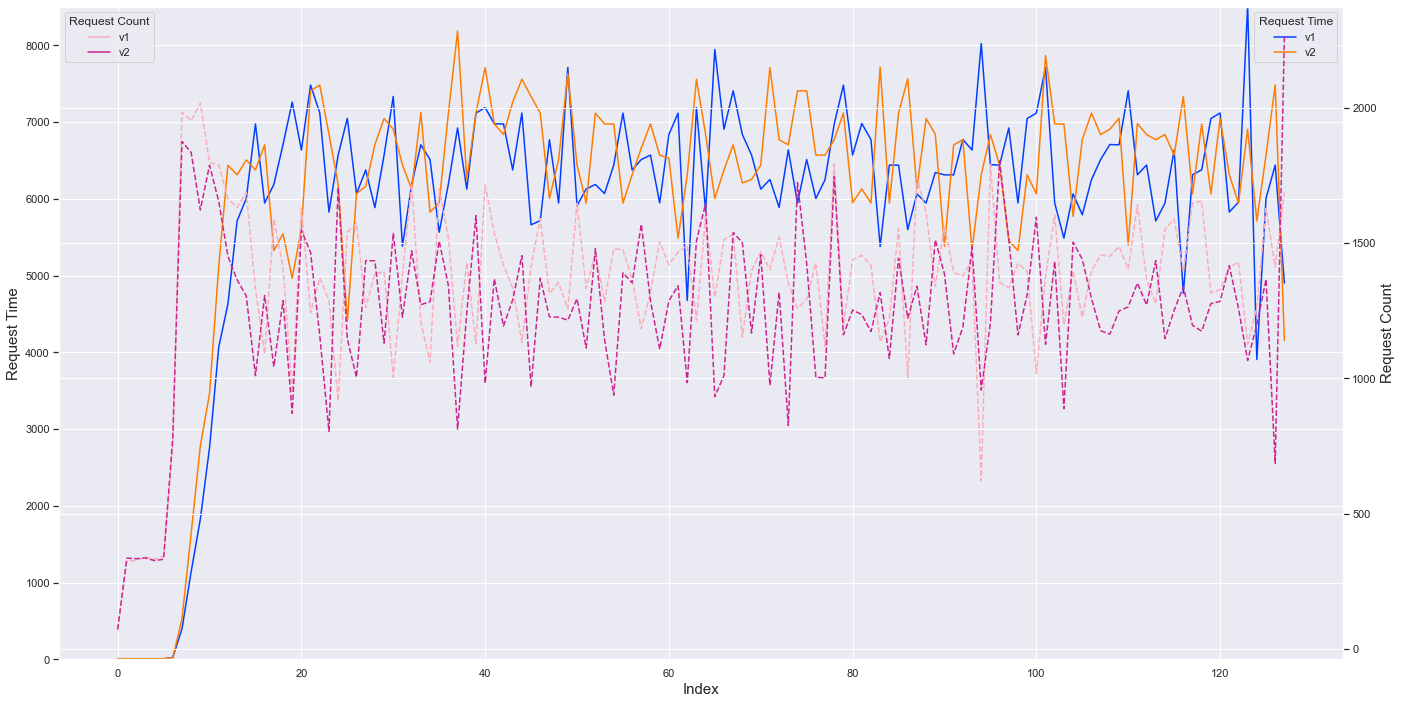

In [11]:

paletteTime = sns.color_palette("bright", 2)
paletteCount = sns.color_palette("RdPu", 2)

sns.set(rc={'figure.figsize':(23,12)})
g = sns.lineplot(data = df_grouped, x='index', y='request_time_median', hue='version', palette=paletteTime)
g.set_xlabel("Index", fontsize = 15)
g.set_ylabel("Request Time", fontsize = 15)
g.set_ylim([0, 8500])
g.legend(title="Request Time")
ax2 = g.twinx()
ax2.set_ylabel("Request Count", fontsize = 15)
#ax2.set_ylim([0, 2000])
g2 = sns.lineplot(data = df_grouped, x='index', y='request_count', hue='version', ax=ax2, palette=paletteCount, linestyle="--")
g2.legend(title="Request Count", loc = 'upper left')

In [12]:
# use index
df_filtered = df_grouped[df_grouped['request_count'] > 500]
df_filtered

,index,version,request_time_median,request_count
12,6,v1,23.90,755
13,6,v2,20.45,782
14,7,v1,395.55,1983
15,7,v2,528.65,1875
16,8,v1,1141.65,1952
...,...,...,...,...
251,125,v2,6569.80,1366
252,126,v1,6439.70,1411
253,126,v2,7485.30,686
254,127,v1,4902.05,1686


In [13]:
measurementIndexesSize = df_filtered['index'].max() - df_filtered['index'].min()
measurementIndexesSize

121

In [14]:
def bootstrap(perfRuntimes1: pd.DataFrame, perfRuntimes2: pd.DataFrame):
  numberOfSamples = 10000
  allRuntimes1 = perfRuntimes1['request_time_median'].to_numpy()
  allRuntimes2 = perfRuntimes2['request_time_median'].to_numpy()
  currentMeasurementIndexes = rng.choice(measurementIndexesSize, size=(measurementIndexesSize, numberOfSamples))

  # Bulk selection
  tmp1 = allRuntimes1[currentMeasurementIndexes]
  tmp1 = np.stack(tmp1, axis=1)
  tmp2 = allRuntimes2[currentMeasurementIndexes]
  tmp2 = np.stack(tmp2, axis=1)

  # Get median for both lists
  med1 = np.median(tmp1, axis=1)
  med2 = np.median(tmp2, axis=1)
  R = med2/med1
  R.sort()

  CIsmall = 1 # 99% confidence interval
  small = int((numberOfSamples * CIsmall) / 100 / 2)
  if small == 0: small = 1
  minSmall = R[small-1]
  minSmall = (minSmall - 1) * 100
  maxSmall = R[numberOfSamples-small-1]
  maxSmall = (maxSmall - 1) * 100
  instability = maxSmall - minSmall
  return minSmall, maxSmall, instability

In [15]:
runtimes1 = df_filtered[df_filtered["version"] == 'v1']
runtimes2 = df_filtered[df_filtered["version"] == 'v2']
median1 = runtimes1['request_time_median'].median()
median2 = runtimes2['request_time_median'].median()
change = ((median2/median1) - 1) * 100
minci, maxci, instability = bootstrap(runtimes1, runtimes2)
assert maxci >= change
assert change >= minci
print(f"performance change: {change:.2f}% [{minci:.2f} - {maxci:.2f}] ({instability:.2f}%)")

performance change: 3.02% [-1.90 - 8.31] (10.21%)
